# tensors

In [ ]:
#| default_exp tensors

In [ ]:
#| hide
#| export
from typing import Optional, Union
import math

from nbdev.showdoc import *
from PIL import Image

from matplotlib import pyplot as plt
from IPython.core.pylabtools import print_figure

import torch

from fastcore.test import test, test_eq, is_close
from fastcore.foundation import patch_to

# import wandb

In [ ]:
# |exporti
class __PrinterOptions(object):
    precision: int = 3
    threshold_max: int = 3 # .abs() larger than 1e3 -> Sci mode
    threshold_min: int = -4 # .abs() smaller that 1e-4 -> Sci mode
    sci_mode: Optional[bool] = None # None = auto. Otherwise, force sci mode.
    indent: int = 2 # Indent for .deeper()
    color: bool = False


In [ ]:
# |export
PRINT_OPTS = __PrinterOptions()

In [ ]:
# |hide
# |exporti
# Do we want this float in decimal or scientific mode?
def sci_mode(f: float):
    return (abs(f) < 10**(PRINT_OPTS.threshold_min) or
            abs(f) > 10**PRINT_OPTS.threshold_max)

In [ ]:
# |hide
test_eq(sci_mode(1.), False)
test_eq(sci_mode(0.00001), True)
test_eq(sci_mode(10000000), True)

# It would be fine either way, both `e` and `f` formats handle those.
test_eq(sci_mode(float('nan')), False)
test_eq(sci_mode(float('inf')), True) 

In [ ]:
# |hide

# What's happening in the cell below
fmt = f"{{:.{4}{'e'}}}"
fmt, fmt.format(1.23)

('{:.4e}', '1.2300e+00')

In [ ]:
# |export

# Convert a tensor into a string.
# This only looks good for small tensors, which is how it's intended to be used.
def tensor_str(t: torch.Tensor):
    """A slightly better way to print `float` values"""
    if t.dim() == 0:
        v = t.item()
        if t.is_floating_point():
            if not t.is_nonzero():
                return "0."

            sci = (PRINT_OPTS.sci_mode or
                    (PRINT_OPTS.sci_mode is None and sci_mode(v)))

            # The f-string will generate something like "{.4f}", which is used
            # to format the value.
            return f"{{:.{PRINT_OPTS.precision}{'e' if sci else 'f'}}}".format(v)
        else:
            return '{}'.format(v) # Should we use sci mode for large ints too?
    else:
        slices = [tensor_str(t[i]) for i in range(0, t.size(0))]
        return '[' + ", ".join(slices) + ']'

In [ ]:
# |hide
torch.manual_seed(42)
randoms = torch.randn(100)

In [ ]:
nasties = randoms[:12].clone()

nasties[0] *= 10000
nasties[1] /= 10000
nasties[3] = float('inf')
nasties[4] = float('-inf')
nasties[5] = float('nan')
nasties = nasties.reshape((2,6))


In [ ]:
tensor_str(nasties)

'[[1.927e+04, 0.000, 0.901, inf, -inf, nan], [-0.043, -1.605, -0.752, 1.649, -0.392, -1.404]]'

In [ ]:
# |hide
test_eq(tensor_str(nasties), '[[1.927e+04, 0.000, 0.901, inf, -inf, nan], [-0.043, -1.605, -0.752, 1.649, -0.392, -1.404]]')

In [ ]:
# |exporti
# |hide
def space_join(lst):
    # Join non-empty list elements into a space-sepaeated string
    return " ".join( [ l for l in lst if l] )

In [ ]:
# |hide
test_eq(space_join(["Hello", None, "World"]), 'Hello World')

In [ ]:
#| exporti

class LovelyProxy():
    def __init__(self, t: torch.Tensor, plain=False, verbose=False, depth=0, lvl=0, color=None):
        self.t = t
        self.plain = plain
        self.verbose = verbose
        self.depth=depth
        self.lvl=lvl
        self.color=color

    @torch.no_grad()
    def to_str(self):
        t = self.t
        if self.plain:
            return torch._tensor_str._tensor_str(t, indent=0)

        color = PRINT_OPTS.color if self.color is None else self.color
        
        grey_style = "\x1b[38;2;127;127;127m" if color else ""
        red_style = "\x1b[31m" if color else ""
        end_style = "\x1b[0m" if color else ""

        dtnames = { torch.float32: "",
                    torch.float16: "f16",
                    torch.float64: "f64",
                    torch.uint8: "u8",
                    torch.int32: "i32",
                }


        tname = "tensor" if type(t) in [torch.Tensor, torch.nn.Parameter] else type(t).__name__
        dev = str(t.device) if t.device.type != "cpu" else None
        dtype = dtnames[t.dtype] if t.dtype in dtnames else str(t.dtype)[6:]


        grad_fn = "grad_fn" if t.grad_fn else None
        # All tensors along the compute path actually have required_grad=True.
        # Torch __repr__ just dones not show it.
        grad = "grad" if t.requires_grad and not t.grad_fn else None

        shape = str(list(t.shape))

        # Later, we might be indexing 't' with a bool tensor derived from it. 
        # THis takes 4x memory and will result in a CUDA OOM if 't' is very large.
        # Move it to the cpu now - it won't matter for small tensors, and for
        # very large ones we trade a CUDA OOM for a few seconds delay.
        t = t.cpu()

        zeros = grey_style+"all_zeros"+end_style if t.eq(0.).all() and t.numel() > 1 else None
        pinf = red_style+"+inf!"+end_style if t.isposinf().any() else None
        ninf = red_style+"-inf!"+end_style if t.isneginf().any() else None
        nan = red_style+"nan!"+end_style if t.isnan().any() else None

        # zeros = "all_zeros" if not t.count_nonzero() else None
        # pinf = "+inf!" if t.isposinf().any() else None
        # ninf = "-inf!" if t.isneginf().any() else None
        # nan = "nan!" if t.isnan().any() else None

        attention = space_join([zeros,pinf,ninf,nan])

        x = ""
        summary = f"n={t.numel()}" if t.numel() > 5 else None
        if not zeros:
            if t.numel() <= 10: x = tensor_str(t)
            
            # Make sure it's float32. Also, we calculate stats on good values only.

            ft = t[ torch.isfinite(t) ].float()

            minmax = f"x∈[{tensor_str(ft.min())}, {tensor_str(ft.max())}]" if t.numel() > 2 and ft.numel() > 2 else None
            meanstd = f"μ={tensor_str(ft.mean())} σ={tensor_str(ft.std())}" if t.numel() >= 2 and ft.numel() >= 2 else None
            numel = f"n={t.numel()}" if t.numel() > 5 and max(t.shape) != t.numel() else None

            summary = space_join([numel, minmax, meanstd])




        res = tname + space_join([  shape,
                                    summary,
                                    dtype,
                                    grad,
                                    grad_fn,
                                    dev,
                                    attention,
                                    x if not self.verbose else None])

        if self.verbose:
            res += "\n" + torch._tensor_str._tensor_str(t, indent=PRINT_OPTS.indent)

        if self.depth and t.dim() > 1:
            res += "\n"
            # for i in range(t.shape[0]):
                # str = 
            res += "\n".join([
                " "*PRINT_OPTS.indent*(self.lvl+1) +
                str(LovelyProxy(t[i,:], depth=self.depth-1, lvl=self.lvl+1))
                for i in range(t.shape[0])])

        return res
    
    def __repr__(self):
        return self.to_str()

    def __call__(self, depth=0):
        return LovelyProxy(self.t, depth=depth)



Would be _lovely_ if you could see all the important tensor stats too?

In [ ]:
# |export
def lovely(t: torch.Tensor, verbose=False, plain=False, depth=0, color=None):
    return LovelyProxy(t, verbose=verbose, plain=plain, depth=depth, color=color)

In [ ]:
print(lovely(randoms[0]))
print(lovely(randoms[:2]))
print(lovely(randoms[:6].view(2, 3))) # More than 2 elements -> show statistics
print(lovely(randoms[:11])) # More than 10 -> suppress data output


tensor[] 1.927
tensor[2] μ=1.707 σ=0.311 [1.927, 1.487]
tensor[2, 3] n=6 x∈[-2.106, 1.927] μ=0.276 σ=1.594 [[1.927, 1.487, 0.901], [-2.106, 0.678, -1.235]]
tensor[11] x∈[-2.106, 1.927] μ=0.046 σ=1.384


In [ ]:
# |hide
test_eq(str(lovely(randoms[0])), "tensor[] 1.927")
test_eq(str(lovely(randoms[:2])), "tensor[2] μ=1.707 σ=0.311 [1.927, 1.487]")
test_eq(str(lovely(randoms[:6].view(2, 3))), "tensor[2, 3] n=6 x∈[-2.106, 1.927] μ=0.276 σ=1.594 [[1.927, 1.487, 0.901], [-2.106, 0.678, -1.235]]")
test_eq(str(lovely(randoms[:11])), "tensor[11] x∈[-2.106, 1.927] μ=0.046 σ=1.384")

In [ ]:
grad = torch.tensor(1., requires_grad=True)
print(lovely(grad)); print(lovely(grad+1))

tensor[] grad 1.000
tensor[] grad_fn 2.000


In [ ]:
# |hide
test_eq(str(lovely(grad)), "tensor[] grad 1.000")
test_eq(str(lovely(grad+1)), "tensor[] grad_fn 2.000")

In [ ]:
if torch.cuda.is_available():
    print(lovely(torch.tensor(1., device=torch.device("cuda:0"))))
    test_eq(str(lovely(torch.tensor(1., device=torch.device("cuda:0")))), "tensor[] cuda:0 1.000")

tensor[] cuda:0 1.000


Do we have __any__ floating point nasties? Is the tensor __all__ zeros?

In [ ]:
PRINT_OPTS.color=True

# Statistics and range are calculated on good values only, if there are at lest 3 of them.
lovely(nasties)


tensor[2, 6] n=12 x∈[-1.605, 1.927e+04] μ=2.141e+03 σ=6.423e+03 +inf! -inf! nan!

In [ ]:
lovely(nasties, color=False)

tensor[2, 6] n=12 x∈[-1.605, 1.927e+04] μ=2.141e+03 σ=6.423e+03 +inf! -inf! nan!

In [ ]:
lovely(torch.tensor([float("nan")]*11))

tensor[11] nan!

In [ ]:
lovely(torch.zeros(12))

tensor[12] n=12 all_zeros

In [ ]:
test_eq(str(lovely(nasties)),
    'tensor[2, 6] n=12 x∈[-1.605, 1.927e+04] μ=2.141e+03 σ=6.423e+03 \x1b[31m+inf!\x1b[0m \x1b[31m-inf!\x1b[0m \x1b[31mnan!\x1b[0m')
test_eq(str(lovely(torch.tensor([float("nan")]*11))), 'tensor[11] \x1b[31mnan!\x1b[0m')
test_eq(str(lovely(torch.zeros(12))), 'tensor[12] n=12 \x1b[38;2;127;127;127mall_zeros\x1b[0m')

In [ ]:
torch.set_printoptions(linewidth=120)

lovely(nasties, verbose=True)

tensor[2, 6] n=12 x∈[-1.605, 1.927e+04] μ=2.141e+03 σ=6.423e+03 +inf! -inf! nan!
[[ 1.9269e+04,  1.4873e-04,  9.0072e-01,         inf,        -inf,         nan],
   [-4.3067e-02, -1.6047e+00, -7.5214e-01,  1.6487e+00, -3.9248e-01, -1.4036e+00]]

In [ ]:
lovely(nasties, plain=True)

[[ 1.9269e+04,  1.4873e-04,  9.0072e-01,         inf,        -inf,         nan],
 [-4.3067e-02, -1.6047e+00, -7.5214e-01,  1.6487e+00, -3.9248e-01, -1.4036e+00]]

In [ ]:
in_stats = { "mean": (0.485, 0.456, 0.406), "std": (0.229, 0.224, 0.225) }

image = torch.load("mysteryman.pt")
image[1,100,100] = float('nan')

lovely(image, depth=1)

tensor[3, 196, 196] n=115248 x∈[-2.118, 2.640] μ=-0.388 σ=1.073 nan!
  tensor[196, 196] n=38416 x∈[-2.118, 2.249] μ=-0.324 σ=1.036
  tensor[196, 196] n=38416 x∈[-1.966, 2.429] μ=-0.274 σ=0.973 nan!
  tensor[196, 196] n=38416 x∈[-1.804, 2.640] μ=-0.567 σ=1.178

In [ ]:
# |exporti

# This is here for the monkey-patched tensor use case.

# I want to be able to call both `tensor.rgb` and `tensor.rgb(stats)`. For the
# first case, the class defines `_repr_png_` to send the image to Jupyter. For
# the later case, it defines __call__, which accps the argument.
class ProxyImage(Image.Image): 
    """Flexible `PIL.Image.Image` wrapper"""
    @torch.no_grad()
    def __init__(self, t:torch.Tensor):
        super().__init__()
        self.t = t.permute(1, 2, 0)

        # Mode and size - to be used by super().__repr__()
        self.mode = "RGB"
        self._size = tuple(t.shape[1:])

    @torch.no_grad()
    def __call__(self, denorm=None):            
        means = torch.tensor(denorm["mean"] if denorm else (0., 0., 0.,), device=self.t.device)
        stds = torch.tensor(denorm["std"] if denorm else (1., 1., 1.,), device=self.t.device)
        return Image.fromarray((self.t*stds+means).mul(255).byte().cpu().numpy())

    @torch.no_grad()
    def _repr_png_(self):
        "Jupyter PNG representation"
        return Image.fromarray(self.t.mul(255).byte().cpu().numpy())._repr_png_()


In [ ]:
# |export
def rgb(t: torch.Tensor, denorm=None):
    return ProxyImage(t)(denorm)

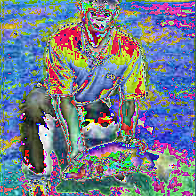

In [ ]:
rgb(image)

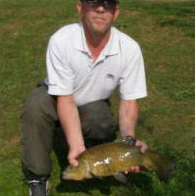

In [ ]:
rgb(image, denorm=in_stats)

In [ ]:
# |hide
# |exporti
def normal_pdf( x: torch.Tensor,
                mean: Union[torch.Tensor, float] =0.,
                std: Union[torch.Tensor, float] =1.):
    r"""Probability Distribution Function of Normal Distribution:
        $$f(x, \mu, \sigma)
        = \dfrac{1}
            {\sigma \sqrt{2\pi} }
        e^{-\frac{1}{2} \left(\frac{x-\mu}{\sigma}\right)^{2}}
        = \dfrac{e^{- \frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{2}}}
            {\sigma \sqrt{2\pi}}$$"""

    dev = x.device
    e = torch.tensor(math.e).to(dev)
    pi = torch.tensor(math.pi).to(dev)

    mean = torch.tensor(mean).to(dev) if not isinstance(mean, torch.Tensor) else mean
    std = torch.tensor(std).to(dev) if not isinstance(std, torch.Tensor) else std

    return (e
                .pow( -0.5 * ((x - mean)/std).pow(2) )
                .div((std * (pi * 2).sqrt()))
            )


In [ ]:
# |hide
# |eval: false
import scipy
x = torch.arange(-4, 4, 0.01)
y1 = torch.tensor(scipy.stats.norm.pdf(x, 2, 3))
y2 = normal_pdf(x, 2, 3)

test_eq(is_close(y1, y2), True)

In [ ]:
# |export
@torch.no_grad()
def hist(t: torch.Tensor, ax=None, center="zero", limit=100000):
    """Plot tensor statistics"""

    assert center in ["zero", "mean", "range"]

    t_str = str(lovely(t, color=False))

    # `t`` may have nasty things like 'nan' and 'inf'. Could also be of non-float type.
    t = t.cpu()

    # Same as in `lovely`, we have to move it to cpu before good-value indexing.
    t = t[ torch.isfinite(t) ].float()

    t_min, t_max = t.min(), t.max()
    t_mean, t_std = t.mean(), t.std()
    
    # `t` might be not on CPU. `t` also might be pretty large. If the tensor is large,
    # randomly sample up to `limit` before moving it to cpu. Here sampling does
    # not cause excessice CUDA memory allocation, because the index tensor is not large.   
    if t.numel() > limit:
        # For efficieny reasons, we have to sample with replacement.
        idxs = torch.randint(low=0, high=t.numel(), size=(limit,), device=t.device)
        t = t.flatten()[idxs]
        t_str = f"{limit} samples of " + t_str

    if t.numel() < 10:
        return
    

    fig = None
    if not ax:
        fig, ax = plt.subplots(figsize=(12, 2), layout="tight")
        plt.close(fig)
    # How far, in sigmas, is the min or max value away from the mean.
    max_sigma = max(int(((t_mean - t_min) / t_std).abs().floor()),
                    int(((t_max - t_mean) / t_std).abs().floor()))

    if center == "range":
        # X limits should center the plot around the mean value
        # x_limit = max(t_min.abs().item(), t_max.abs().item())
        x_limits = [t_min, t_max]
    elif center == "mean":
        x_limit = max(t_mean - t_min.abs().item(), t_max.abs().item() - t_mean)
        x_limits = [t_mean - x_limit, t_mean + x_limit]
    else:
        # X limits should center the plot around zero
        x_limit = max(t_min.abs().item(), t_max.abs().item(),
                    (t_mean-max_sigma*t_std).item(), (t_mean+max_sigma*t_std).item())
        x_limits = [-x_limit, x_limit]

    bins = t.numel() / 50
    bins = max(min(bins, 100), 10)

    histc = t.histc(bins=bins, min=t_min, max=t_max)

    bar_edges = torch.linspace(t_min, t_max, bins+1)[:bins]
    bar_width = bar_edges[:2].diff()

    # Histogram normalized to look like PDF: area under histogram = 1.
    histc_density = (histc / (histc.sum() * bar_width))
    ax.bar(x=bar_edges.numpy(), height=histc_density.numpy(), width=bar_width, color="deepskyblue", align="edge", zorder=4,)

    # PDF of normal distribution with the same mean and std.
    x = torch.linspace(*x_limits, 100)
    normal_density = normal_pdf(x, mean=t_mean, std=t_std)
    ax.plot(x, normal_pdf(x, mean=t_mean, std=t_std), zorder=5)

    y_lim = max(histc_density.max().item(), normal_density.max().item()) * 1.3

    # Make text bank part of the line under it
    bbox = dict(boxstyle="round", fc="white", edgecolor="none")

    for s in range(-max_sigma, max_sigma+1):
        x_pos = (t_mean + s*t_std).item()
        greek = ["-σ", "μ", "+σ"][s+1]  if -1 <= s <= 1 else f"{s:+}σ"
        ax.axvline(x_pos, 0, 1, c="black")
        ax.text(x_pos, y_lim*0.95, greek, ha="center", va="top", bbox=bbox, zorder=5)

    # 2 red lines for min and max values
    ax.annotate(
        f"min={tensor_str(t_min)}",
        (t_min.item(), y_lim/2),
        xytext=(-1, 0), textcoords='offset points',
        bbox=bbox,
        rotation=90,
        ha="right",
        va="center"
        )

    ax.annotate(
        f"max={tensor_str(t_max)}",
        (t_max.item(), y_lim/2),
        xytext=(2, 0), textcoords='offset points',
        bbox=bbox,
        rotation=90,
        ha="left",
        va="center"
        )

    ax.axvline(t_min.item(), 0, 1, c="red", zorder=4)
    ax.axvline(t_max.item(), 0, 1, c="red", zorder=4)

    ax.text(x_limits[0]*1.05, y_lim*1.05, s=t_str)
    ax.set_ylim(0, y_lim)
    ax.set_yticks([])

    # ax.set_xlim( x_limits[0]*1.05, x_limits[1]*1.05 )

    return fig
    

In [ ]:
# |exporti

# This is here for the monkey-patched tensor use case.
# Gives the ability to call both .plt and .plt(ax=ax).  

class ProxyPlot(): 
    """Flexible `PIL.Image.Image` wrapper"""
    @torch.no_grad()
    def __init__(self, t:torch.Tensor, ax=None, center="zero", fmt="svg"):
        self.t = t
        self.ax = ax
        self.center = center
        self.fmt = fmt
        
        assert fmt in ["png", "svg"]
        assert center in ["zero", "mean", "range"]

    def __call__(self, ax=None, center="zero", fmt="svg"):
        return ProxyPlot(self.t, ax=ax, center=center)

    # Do an explicit print_figure instead of relying on IPythons repr formatter
    # for pyplot.Figure. Mainly for speed.
    #
    # IPython will attempt to render the figure in a bunch of formats, and then
    # pick one to show, and this takes a noticeable amount of time. Render just
    # one format instead.
    
    def _repr_svg_(self):
        if self.fmt == "svg":
            return print_figure(hist(self.t, self.ax, self.center), fmt="svg")

    def _repr_png_(self):
        if self.fmt == "png":
            return print_figure(hist(self.t, self.ax, self.center), fmt="png")

In [ ]:
# |export
def monkey_patch(cls=torch.Tensor):
    "Monkey-patch lovely features into `cls`" 

    @patch_to(cls)
    def __repr__(self: torch.Tensor, *, tensor_contents=None):        
        return str(LovelyProxy(self))

    # Keep an esiy way to get the standard behavior.
    @patch_to(cls, as_prop=True)
    def plain(self: torch.Tensor, *, tensor_contents=None):
        return LovelyProxy(self, plain=True)

    # And a verbose option for a good measure.
    @patch_to(cls, as_prop=True)
    def verbose(self: torch.Tensor, *, tensor_contents=None):
        return LovelyProxy(self, verbose=True)

    @patch_to(cls, as_prop=True)
    def deeper(self: torch.Tensor):
        return LovelyProxy(self, depth=1)

    @patch_to(cls, as_prop=True)
    def rgb(t: torch.Tensor):
        return ProxyImage(t)

    @patch_to(cls, as_prop=True)
    def plt(t: torch.Tensor):
        return ProxyPlot(t)

In [ ]:
monkey_patch()

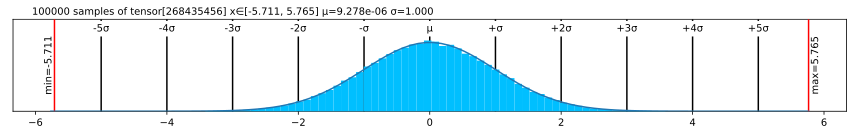

In [ ]:
# |eval: false
numbers = torch.randn(1024*1024*256) # 1Gb of numbers
fig = numbers.plt # 3.6 seconds on my CPU. Decet.
del numbers
fig

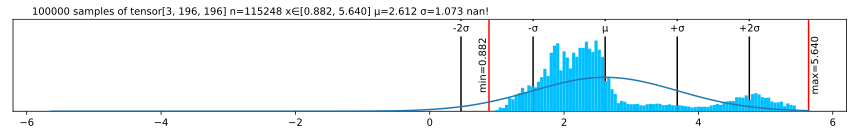

In [ ]:
(image+3).plt

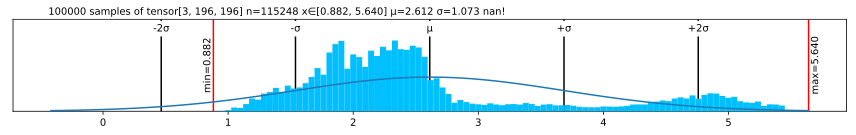

In [ ]:
(image+3).plt(center="mean")

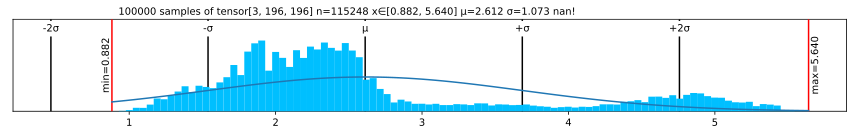

In [ ]:
(image+3).plt(center="range")

In [ ]:
nasties.verbose

tensor[2, 6] n=12 x∈[-1.605, 1.927e+04] μ=2.141e+03 σ=6.423e+03 +inf! -inf! nan!
[[ 1.9269e+04,  1.4873e-04,  9.0072e-01,         inf,        -inf,         nan],
   [-4.3067e-02, -1.6047e+00, -7.5214e-01,  1.6487e+00, -3.9248e-01, -1.4036e+00]]

In [ ]:
nasties.plain

[[ 1.9269e+04,  1.4873e-04,  9.0072e-01,         inf,        -inf,         nan],
 [-4.3067e-02, -1.6047e+00, -7.5214e-01,  1.6487e+00, -3.9248e-01, -1.4036e+00]]

In [ ]:
# Per-channel statistics of an image
# image.deeper*1000

In [ ]:
# Not sure it we are back to the "too many numbers" territory here, but
# if you want to go deeper, you can.

dt = torch.randn(3, 3, 5)
dt.deeper(3)

tensor[3, 3, 5] n=45 x∈[-2.210, 1.878] μ=0.049 σ=0.858
  tensor[3, 5] n=15 x∈[-1.119, 1.438] μ=0.061 σ=0.723
    tensor[5] x∈[-0.804, 1.438] μ=-0.151 σ=0.922 [-0.751, 1.438, -0.444, -0.804, -0.196]
    tensor[5] x∈[-0.242, 0.894] μ=0.105 σ=0.465 [-0.242, 0.002, -0.231, 0.894, 0.103]
    tensor[5] x∈[-1.119, 1.107] μ=0.230 σ=0.817 [-1.119, 0.341, 0.406, 1.107, 0.417]
  tensor[3, 5] n=15 x∈[-1.270, 1.878] μ=0.163 σ=0.818
    tensor[5] x∈[-1.270, 0.567] μ=-0.392 σ=0.757 [0.567, 0.150, -0.943, -0.462, -1.270]
    tensor[5] x∈[-0.160, 1.878] μ=0.639 σ=0.813 [0.488, -0.160, 0.945, 1.878, 0.042]
    tensor[5] x∈[-0.833, 0.773] μ=0.243 σ=0.659 [-0.833, 0.773, 0.398, 0.756, 0.122]
  tensor[3, 5] n=15 x∈[-2.210, 1.531] μ=-0.076 σ=1.043
    tensor[5] x∈[-0.815, 1.531] μ=0.220 σ=0.844 [-0.815, 0.175, -0.022, 1.531, 0.234]
    tensor[5] x∈[-0.794, 0.732] μ=0.202 σ=0.680 [0.732, -0.224, 0.662, -0.794, 0.632]
    tensor[5] x∈[-2.210, 1.439] μ=-0.651 σ=1.419 [1.439, -1.389, 0.040, -1.135, -2.210]

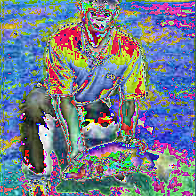

In [ ]:
image.rgb

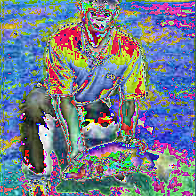

In [ ]:
image.rgb()

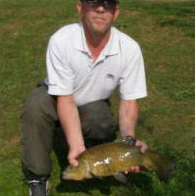

In [ ]:
image.rgb(in_stats)

In [ ]:
# |hide
import scipy.stats

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()